In [1]:
%matplotlib inline

import cv2
import numpy as np
import os.path
import sklearn.linear_model
import sklearn.model_selection
import tabulate

from IPython.display import HTML, display
from matplotlib import pyplot as plt

# Set default figure size
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['font.size'] = 30
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['lines.markersize'] = 20
plt.rcParams['lines.markeredgewidth'] = 4

In [2]:
def imread_color(filename):
    """Reads `filename` into a numpy array (channels: R, G, B)"""
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

def imread_gray(filename):
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

def imshow_color(ax, img):
    ax.imshow(img)
    
def imshow_gray(ax, img):
    ax.imshow(img, cmap='gray')
    
def get_patch(img, roi):
    return img[roi[0][1]:roi[1][1],roi[0][0]:roi[1][0]]

def draw_roi(img, roi, color=(255), thickness=3):
    cv2.rectangle(img, roi[0], roi[1], color, thickness)

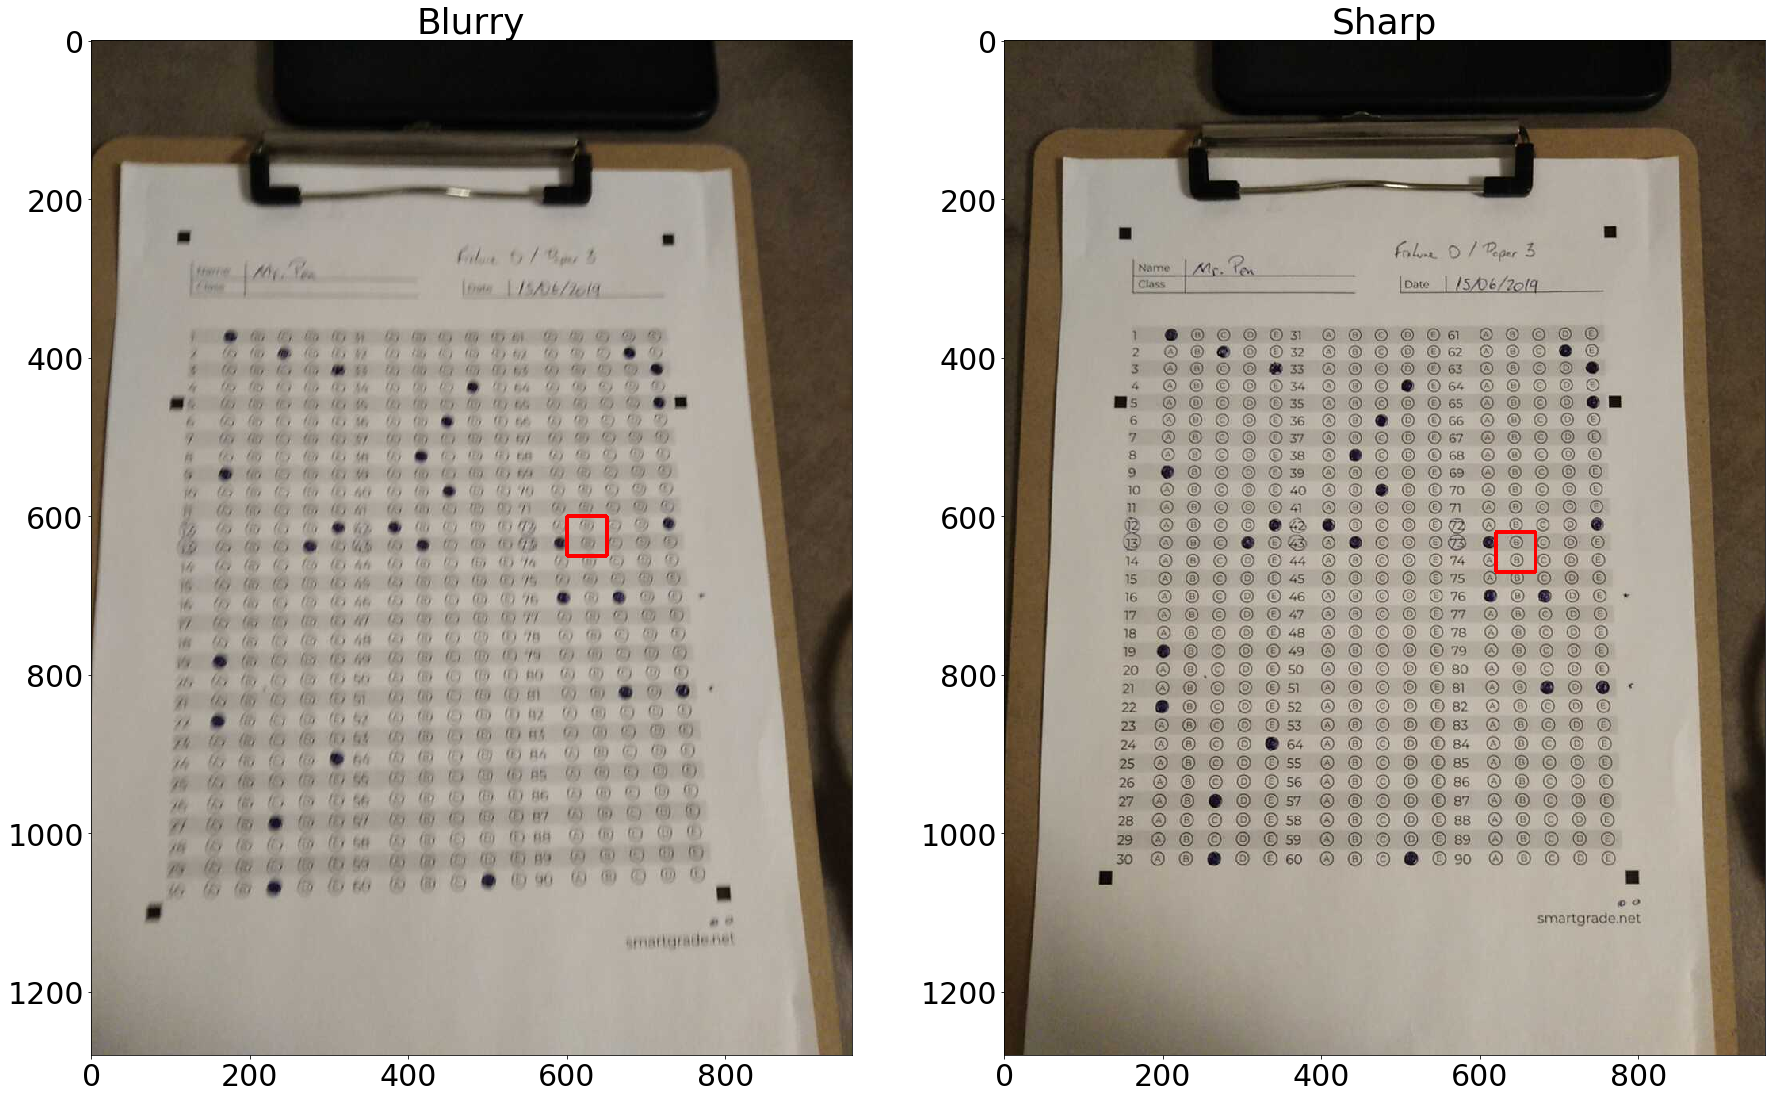

In [3]:
blurry_roi = ((600, 600), (650, 650))
sharp_roi = ((620, 620), (670, 670))

blurry_img_color = imread_color('img/blurry/2020-02-09T17:54:08.347Z.jpg')
sharp_img_color  = imread_color('img/sharp/2020-02-09T17:53:50.500Z.jpg')

fig, axs = plt.subplots(1, 2, figsize=(30,30))

draw_roi(blurry_img_color, blurry_roi)
draw_roi(sharp_img_color, sharp_roi)

blurry_patch = get_patch(blurry_img_color, blurry_roi)
sharp_patch = get_patch(sharp_img_color, sharp_roi)

axs[0].set_title('Blurry')
imshow_gray(axs[0], blurry_img_color)
axs[1].set_title('Sharp')
imshow_gray(axs[1], sharp_img_color)

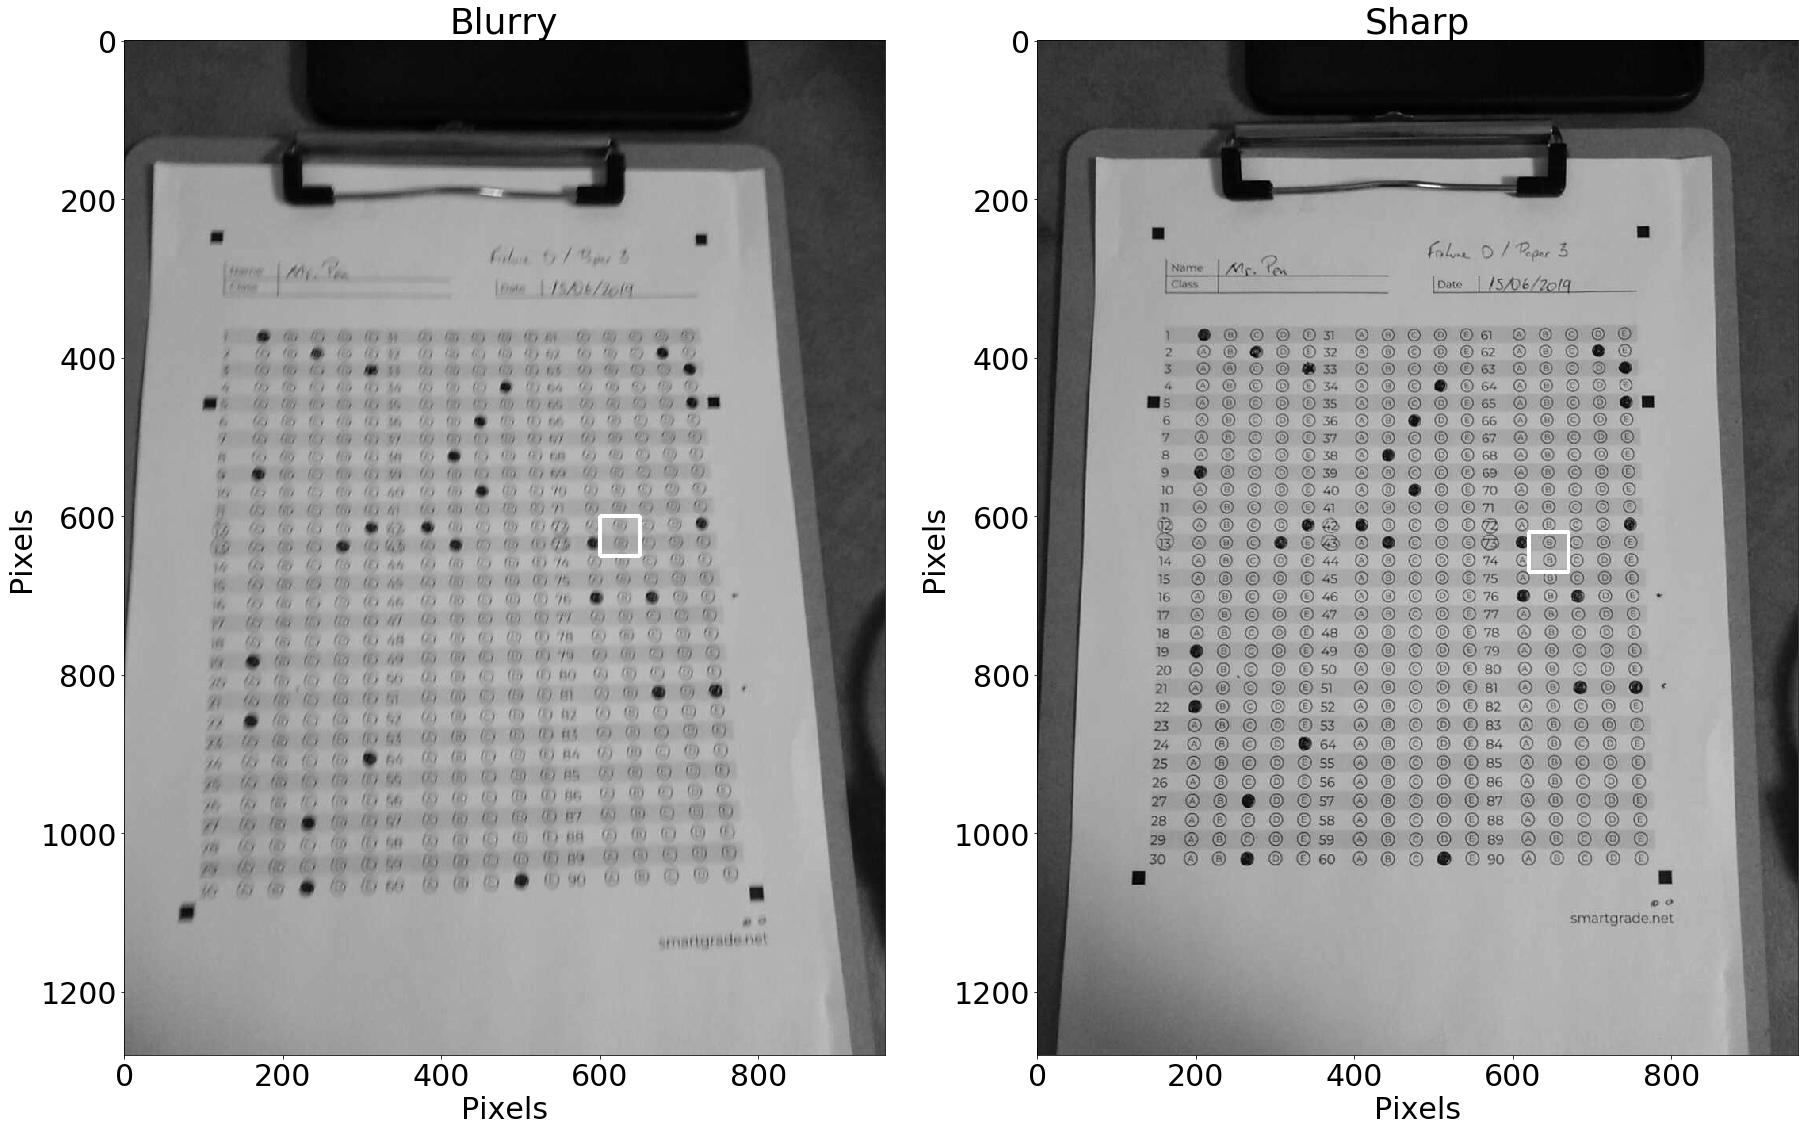

In [4]:
blurry_img = imread_gray('img/blurry/2020-02-09T17:54:08.347Z.jpg')
sharp_img  = imread_gray('img/sharp/2020-02-09T17:53:50.500Z.jpg')

blurry_img_draw = blurry_img.copy()
sharp_img_draw = sharp_img.copy()


draw_roi(blurry_img_draw, blurry_roi)
draw_roi(sharp_img_draw, sharp_roi)

blurry_patch = get_patch(blurry_img, blurry_roi)
sharp_patch = get_patch(sharp_img, sharp_roi)

def plot_pair(blurry_title, blurry_img, sharp_title, sharp_img):
    fig, axs = plt.subplots(1, 2, figsize=(30,30))
    axs[0].set_title(blurry_title)
    axs[0].set_xlabel('Pixels')
    axs[0].set_ylabel('Pixels')
    imshow_gray(axs[0], blurry_img)
    axs[1].set_title(sharp_title)
    axs[1].set_xlabel('Pixels')
    axs[1].set_ylabel('Pixels')
    imshow_gray(axs[1], sharp_img)
    
plot_pair('Blurry', blurry_img_draw, 'Sharp', sharp_img_draw)

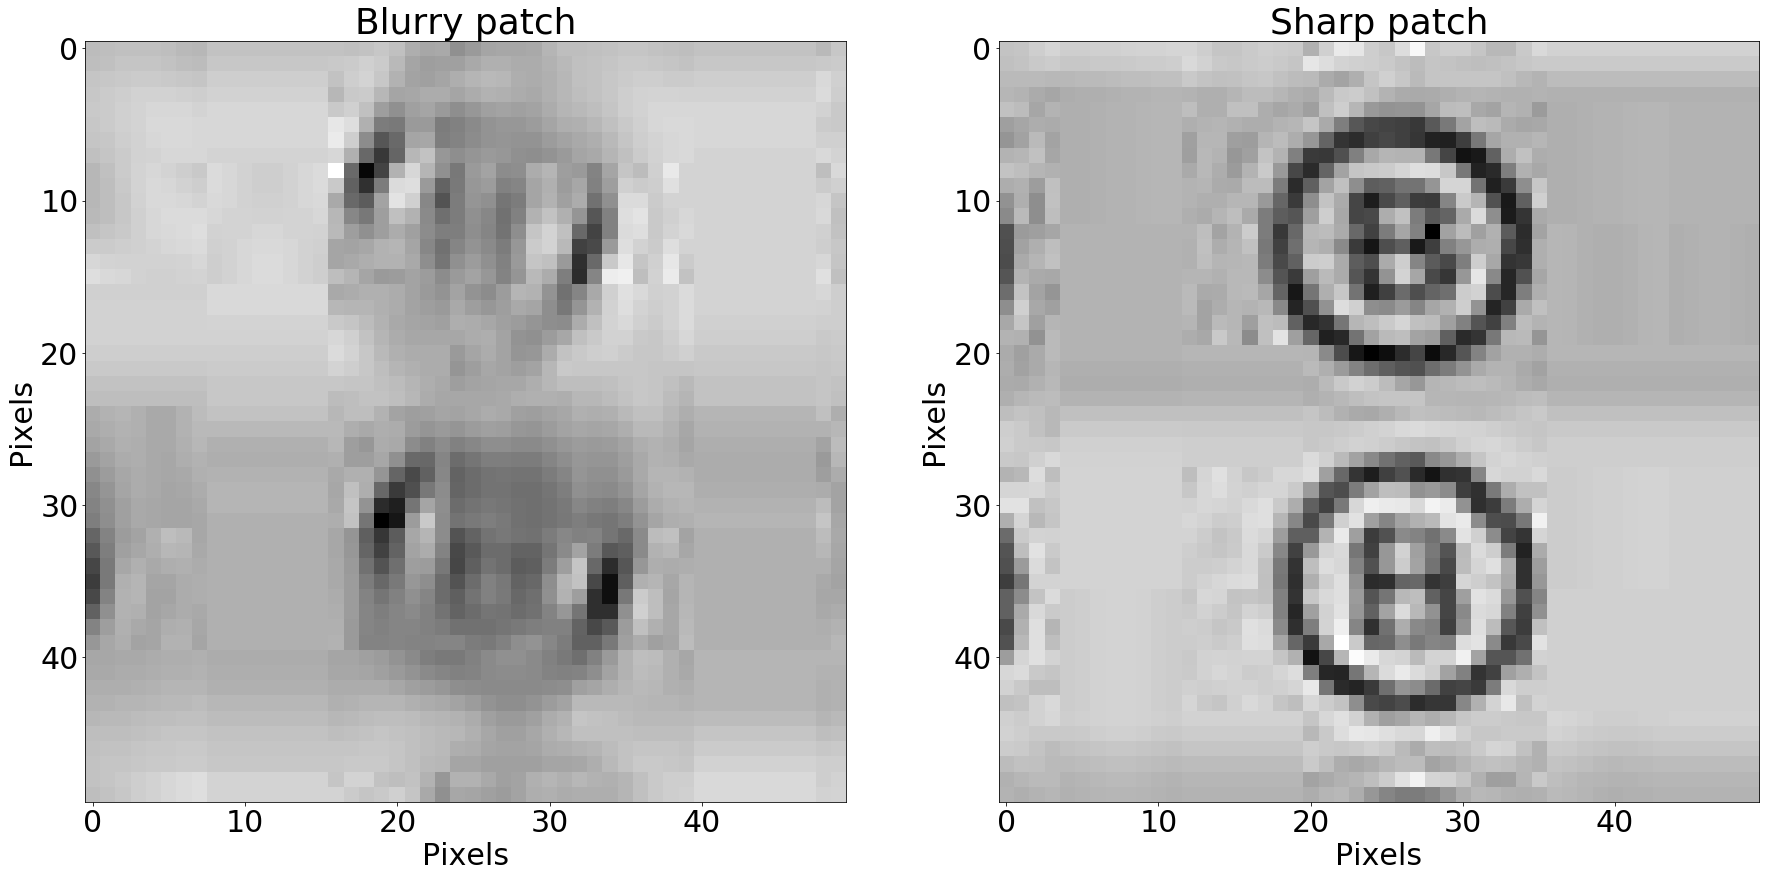

In [5]:
plot_pair('Blurry patch', blurry_patch, 'Sharp patch', sharp_patch)

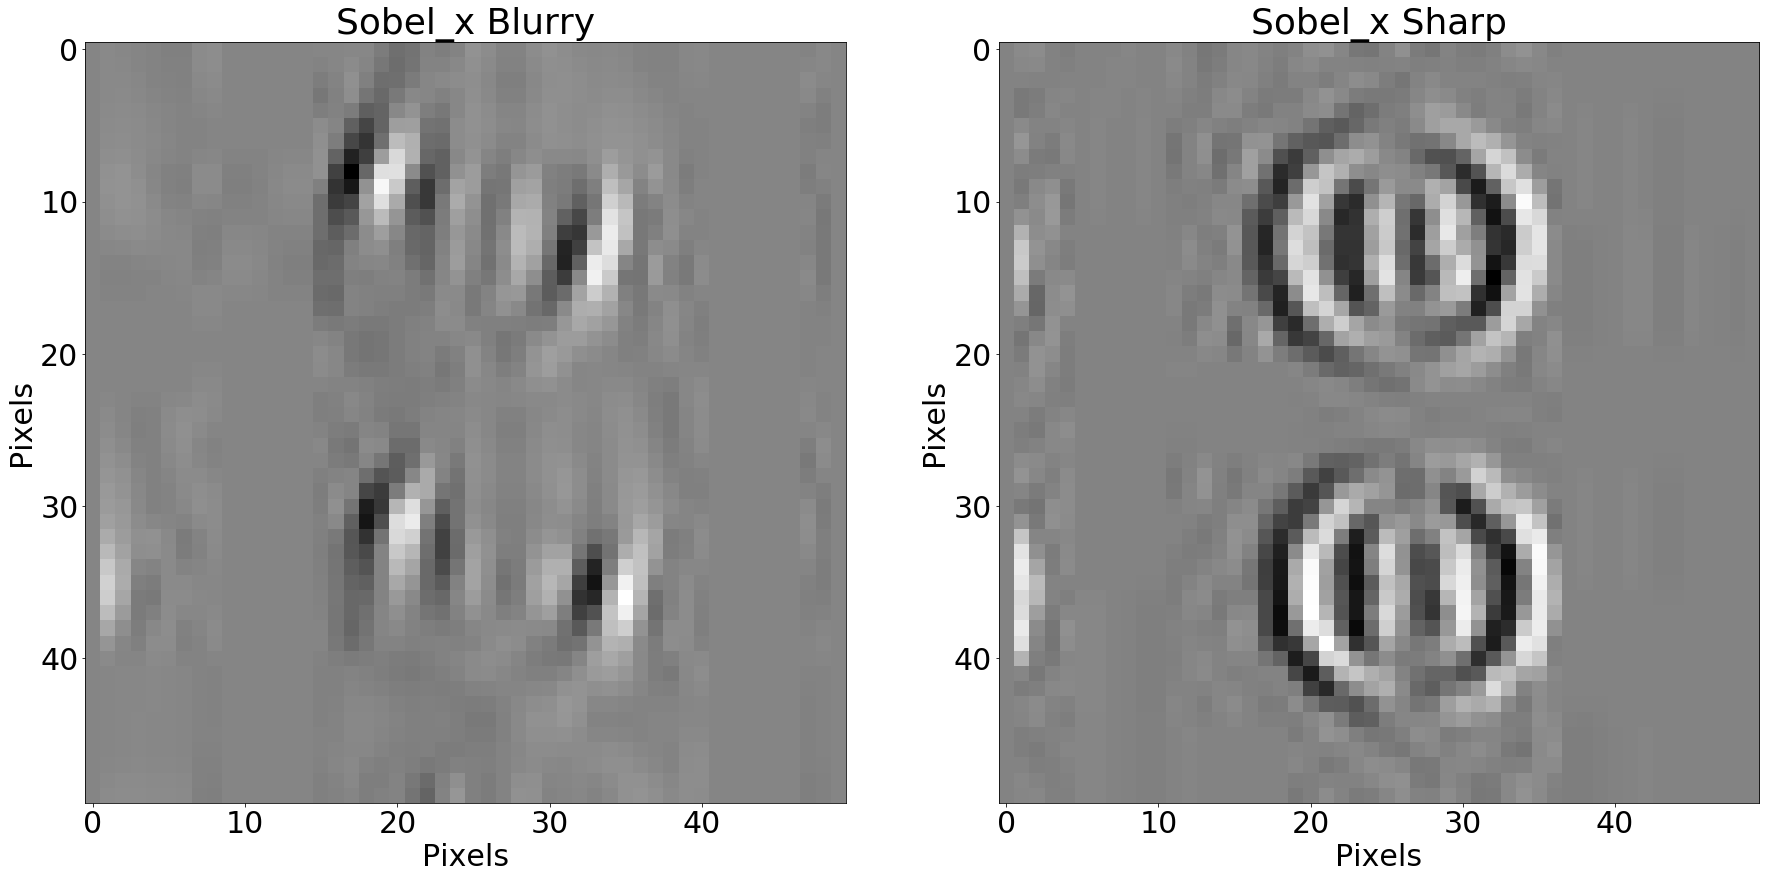

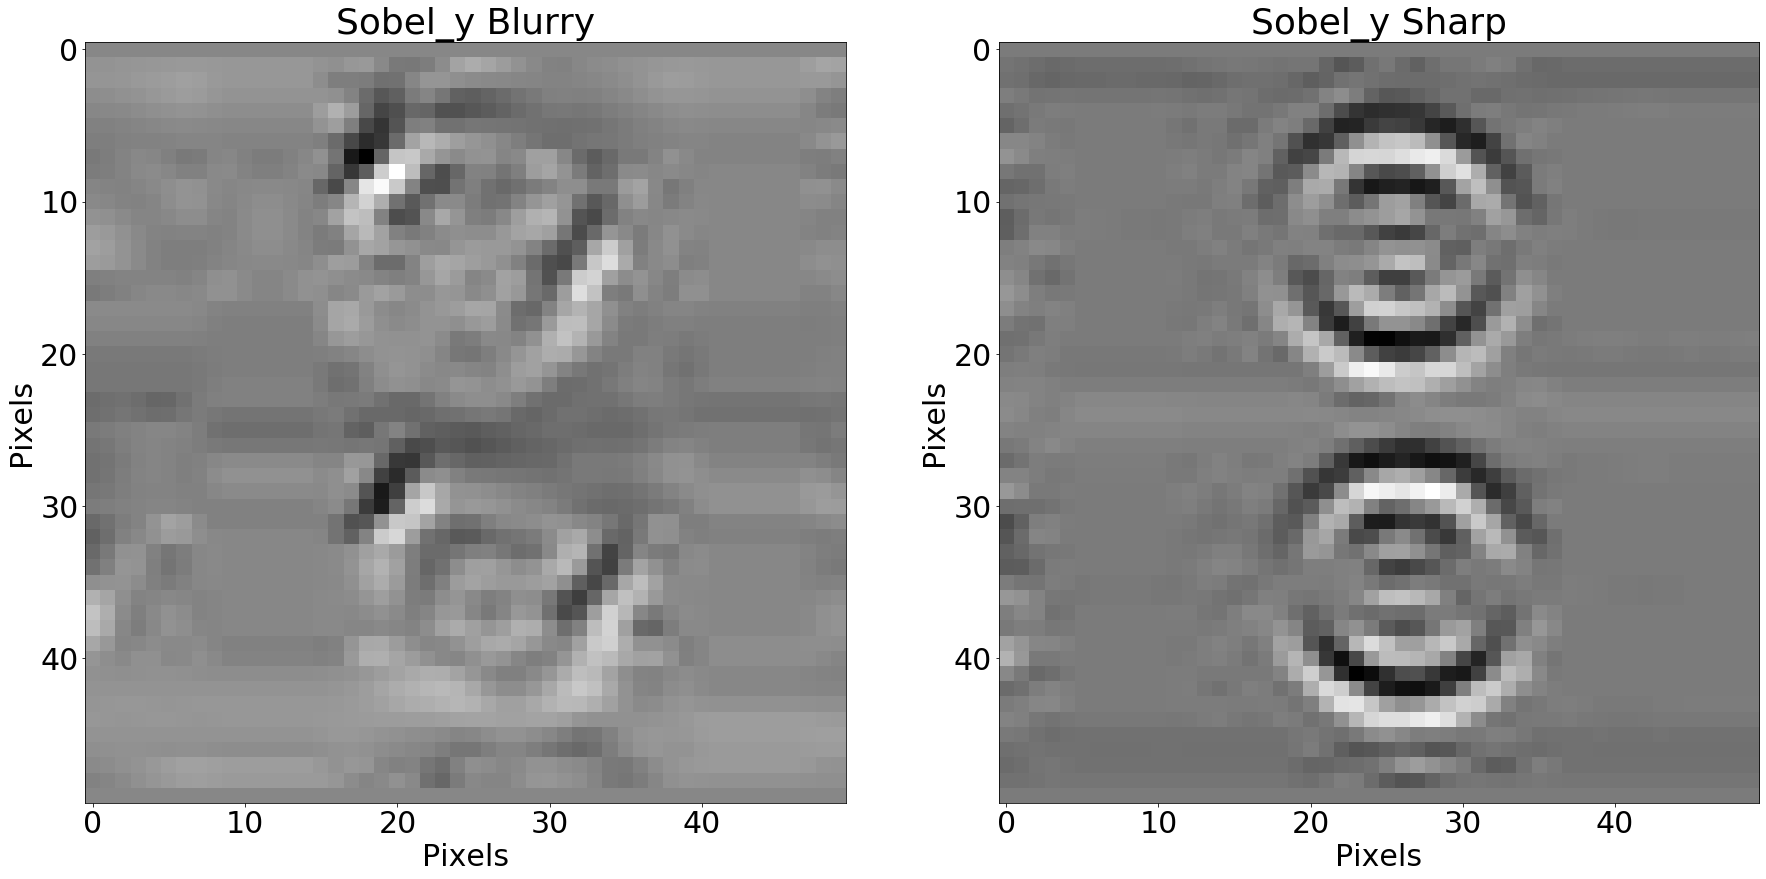

In [6]:
def get_sobel_x(img):
    return cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)

def get_sobel_y(img):
    return cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

plot_pair('Sobel_x Blurry',
          get_sobel_x(blurry_patch),
          'Sobel_x Sharp',
          get_sobel_x(sharp_patch))

plot_pair('Sobel_y Blurry',
          get_sobel_y(blurry_patch),
          'Sobel_y Sharp',
          get_sobel_y(sharp_patch))

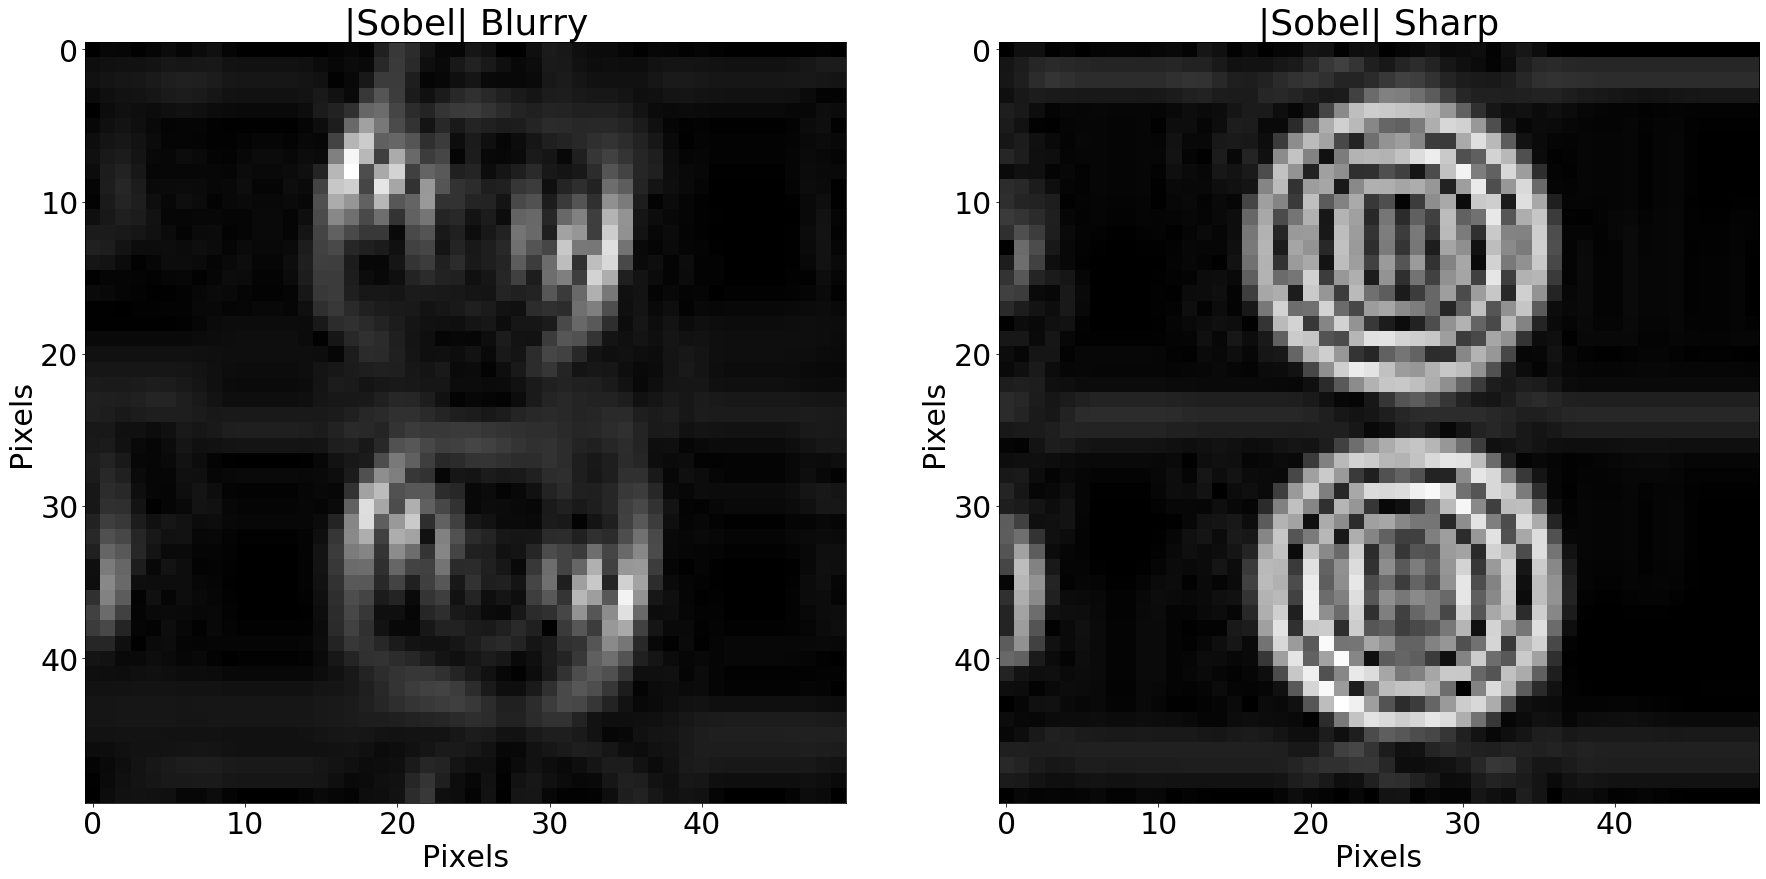

In [7]:
def edges_magnitude(img):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    return cv2.magnitude(sobel_x, sobel_y)

plot_pair('|Sobel| Blurry',
          edges_magnitude(blurry_patch),
          '|Sobel| Sharp',
          edges_magnitude(sharp_patch))

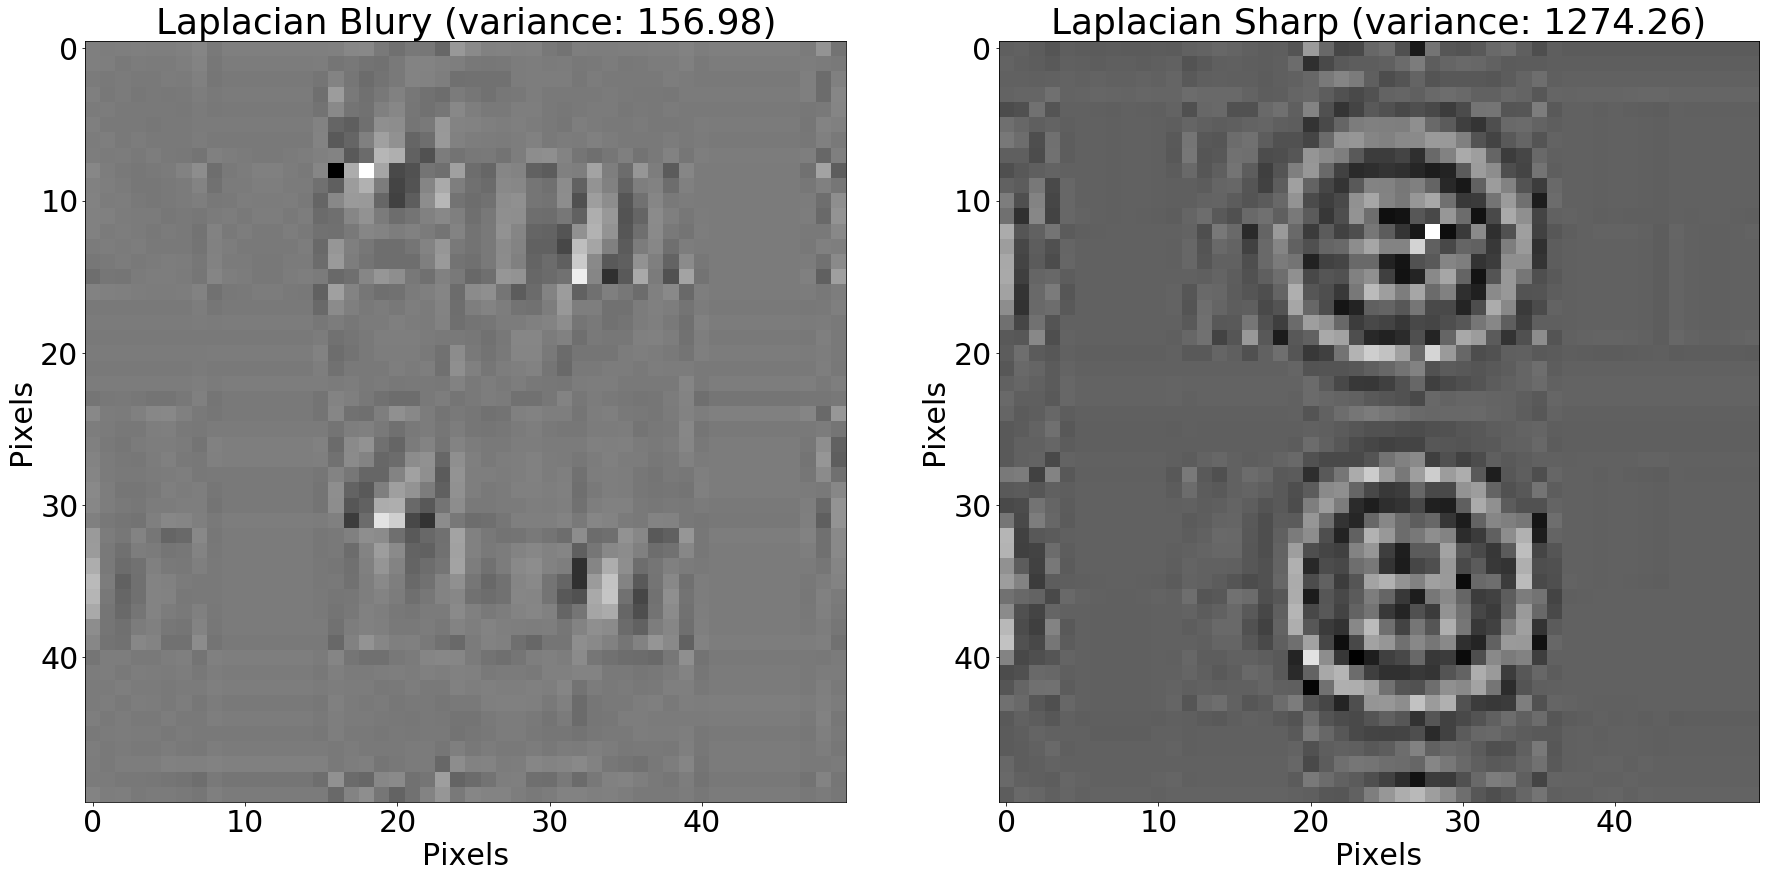

In [8]:
blur_patch_lap = cv2.Laplacian(blurry_patch, cv2.CV_64F)
sharp_patch_lap = cv2.Laplacian(sharp_patch, cv2.CV_64F)

plot_pair(
    f'Laplacian Blury (variance: {blur_patch_lap.var():.2f})',
    blur_patch_lap,
    f'Laplacian Sharp (variance: {sharp_patch_lap.var():.2f})',
    sharp_patch_lap)

In [32]:
def make_training_input(base_dir, folder, filename):
    full_path = os.path.join(base_dir, folder, filename)
    img = imread_gray(full_path)
    y = 1.0 if folder == 'sharp' else 0.0
    return (img, y, full_path)
    
def read_training_inputs(base_dir):
    return [
        make_training_input(base_dir, folder, filename)
        for folder in ('blurry', 'sharp')
        for filename in os.listdir(os.path.join(base_dir, folder))
        if filename.endswith('jpg')
    ]

training_inputs = read_training_inputs('img')
print('Number of examples: ', len(training_inputs))

Number of examples:  64


In [10]:
def pretty_print_table(table):
    table = sorted(training_inputs, key=lambda t: (t[1], t[0]))
    display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [47]:
def train_model(focus_measure_fn, training_inputs):
    training_data = [
        (focus_measure_fn(img), y, filename)
        for (img, y, filename) in training_inputs
    ]
    
    x, y, _ = zip(*training_data)
    X = np.array(x).reshape(-1, 1)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=0.4, random_state=0)
    
    log_reg = sklearn.linear_model.LogisticRegression()
    log_reg.fit(X, y)
    score = log_reg.score(X_test, y_test)
    return (log_reg, score, X, y)

def plot_model(model_name, model, X, y):  
    Xplot = np.arange(X.min(), X.max(), dtype=np.float32)
    yplot = model.predict_proba(Xplot.reshape(-1, 1))
    plt.title(model_name)
    plt.plot(Xplot, yplot[:,1])
    plt.xlabel(model_name)
    plt.ylabel('Is Sharp?')
    Xy = np.concatenate((X, np.array(y).reshape(-1, 1)), axis=1)
    Xy_sharp = Xy[Xy[:,1] > 0.5]
    Xy_blurry = Xy[Xy[:,1] < 0.5]
    plt.scatter(Xy_sharp[:,0], Xy_sharp[:,1], marker='o', label='Sharp')
    plt.scatter(Xy_blurry[:,0], Xy_blurry[:,1], marker='x', label='Blurry')
    plt.legend()
    
def evaluate_focus_measure(model_name, focus_measure_fn, training_input):
    model, score, X, y = train_model(focus_measure_fn, training_input)
    plot_model(model_name, model, X, y)
    return score

In [12]:
def visualize_filter(filter_fn, img):
    fig, axs = plt.subplots(1, 2, figsize=(30,30))
    axs[0].set_title('Original')
    imshow_gray(axs[0], img)
    axs[1].set_title('Filtered')
    imshow_gray(axs[1], filter_fn(img))

0.9230769230769231


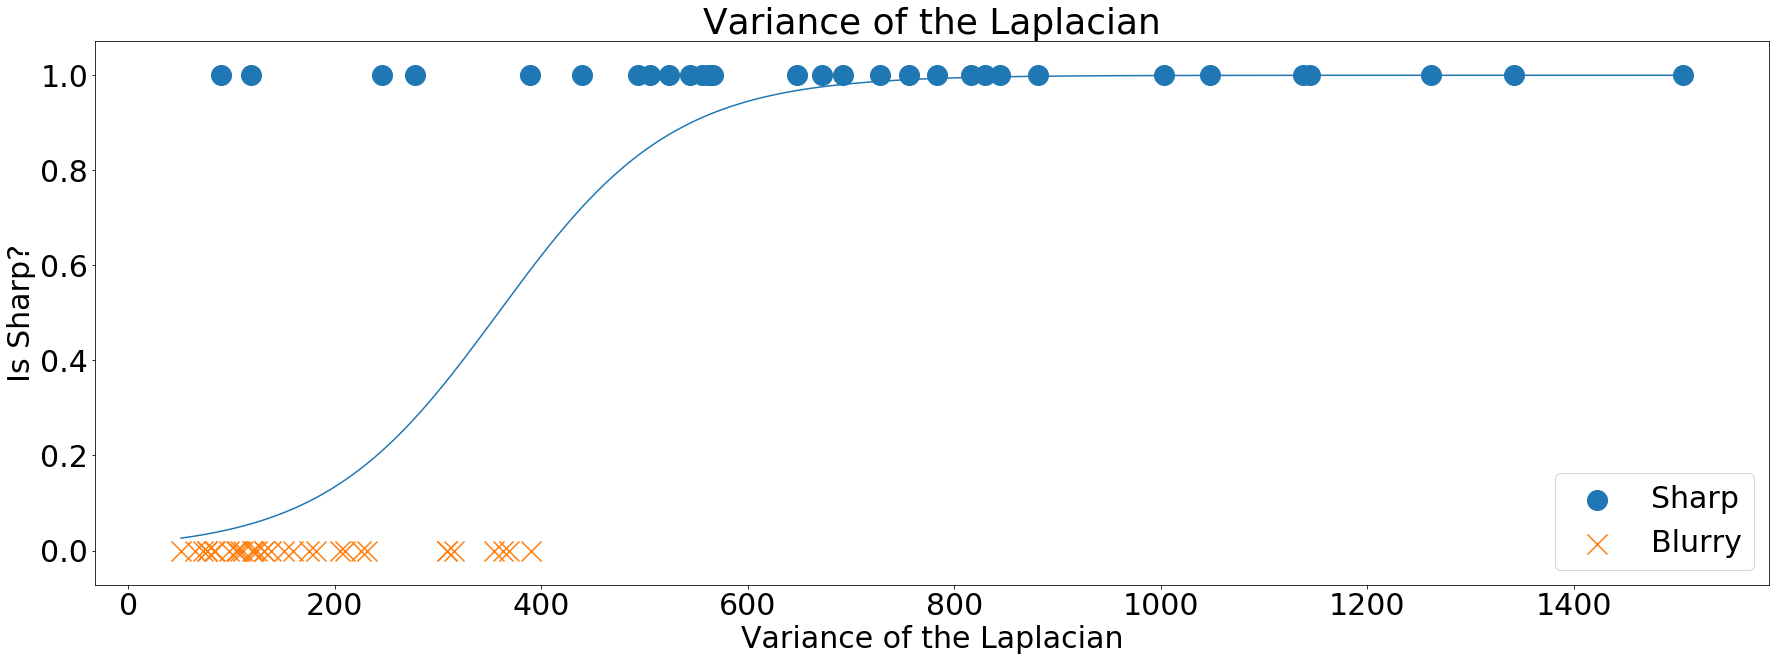

In [49]:
def variance_of_laplacian(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

score = evaluate_focus_measure(
    "Variance of the Laplacian",
    variance_of_laplacian,
    training_inputs)

print(score)

1.0


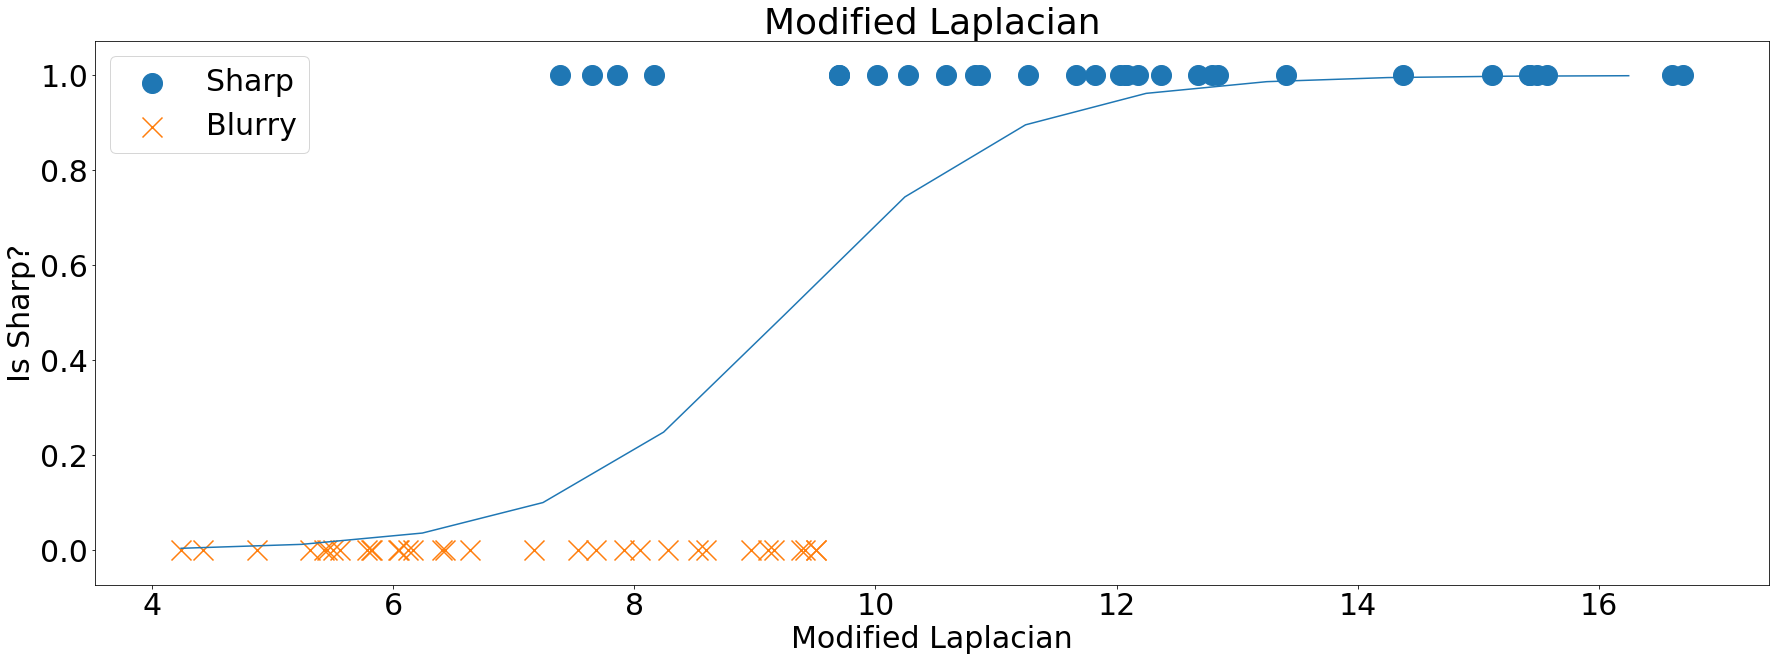

In [50]:
def Lx(img):
    kernelx = np.array([[0, 0, 0], [-1, 2, -1], [0, 0, 0]])
    return cv2.filter2D(img, cv2.CV_32F, np.array(kernelx))

def Ly(img):
    kernely = kernelx = np.array([[0, -1, 0], [0, 2, 0], [0, -1, 0]])
    return cv2.filter2D(img, cv2.CV_32F, np.array(kernely))

def modified_laplacian(img):
    return (np.abs(Lx(img)) + np.abs(Ly(img))).mean()

# visualize_filter(Lx, sharp_patch)
# visualize_filter(Ly, sharp_patch)

score = evaluate_focus_measure(
    "Modified Laplacian",
    modified_laplacian,
    training_inputs)

print(score)

0.9230769230769231


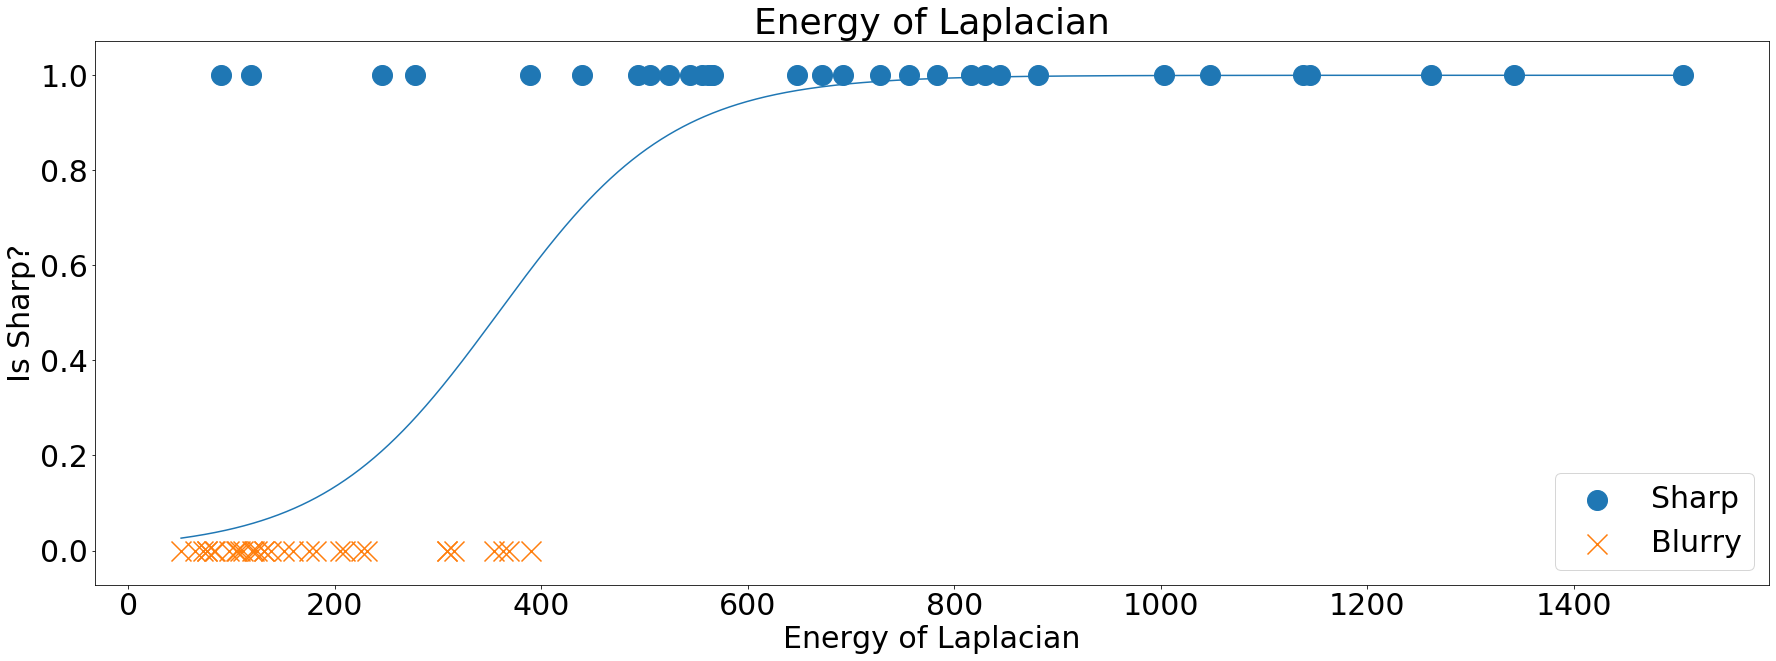

In [51]:
def energy_of_laplacian(img):
    lap = cv2.Laplacian(img, cv2.CV_32F)
    return np.square(lap).mean()

score = evaluate_focus_measure(
    "Energy of Laplacian",
    energy_of_laplacian,
    training_inputs)

print(score)

1.0


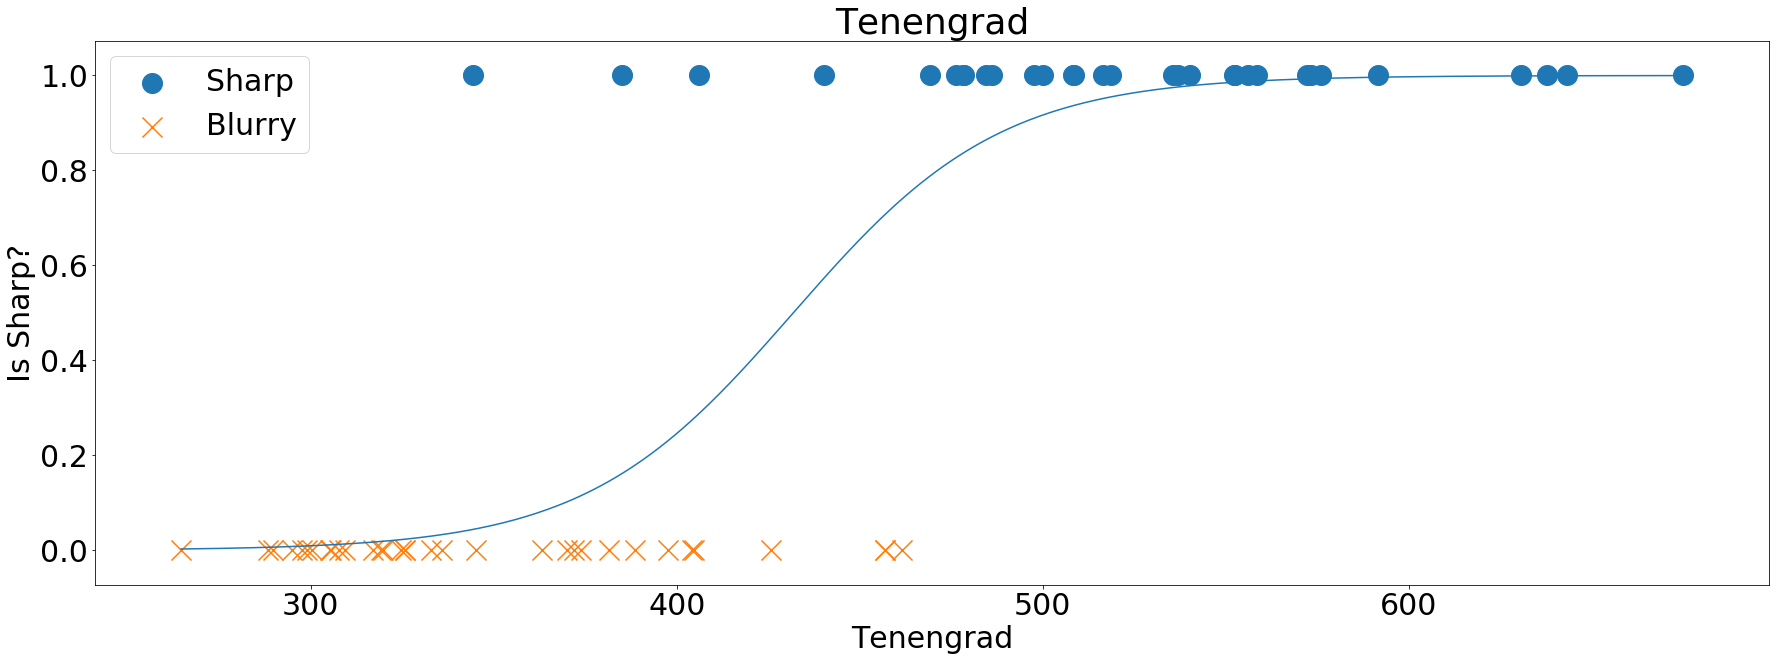

In [52]:
def tenengrad(img):
    sx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=5)
    sy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=5)
    return cv2.magnitude(sx, sy).mean()
    
score = evaluate_focus_measure(
    "Tenengrad",
    tenengrad,
    training_inputs)

print(score)